In [0]:
!pip3 install pystac > x
!pip3 install robosat.pink > x

ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from urllib.parse import urlparse
import requests
from pystac import STAC_IO
import pandas as pd

def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme.startswith('http'):
        return requests.get(uri).text
    else:
        return STAC_IO.default_read_text_method(uri)

STAC_IO.read_text_method = my_read_method

In [0]:
train1_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/catalog.json')
train2_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_2/catalog.json')
test_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/test/catalog.json')

In [0]:
%%shell
rm -rf data
mkdir -p data/tif data/geojson data/urls

In [0]:
def one_tif_geojson():
  tif = 'https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/mon/f15272/f15272.tif'
  geojson = 'https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/mon/f15272-labels/f15272.geojson'
  df = pd.DataFrame({ 'tif': [tif], 'geo': [geojson]} )
  df.to_csv('data/urls/urls.csv', index=False)

In [0]:
def store_dataset_urls(dataset_obj):
  cols = {cols.id:cols for cols in dataset_obj.get_children()}
  image_url = []
  label_url = []
  
  for k, v in cols.items():
      for i in v.get_all_items():
          if 'label' in i.id:
            label_url.append(i.make_asset_hrefs_absolute().assets['labels'].href)
          else: 
            image_url.append(i.make_asset_hrefs_absolute().assets['image'].href)

  df = pd.DataFrame({ 'tif': image_url, 'geo': label_url} )
  df.to_csv('data/urls/urls.csv', index=False)


In [0]:
def restore_from_last_dataset(after_id):
    file = 'data/urls/urls.csv'
    df = pd.read_csv(file)
    index_list = df.index[df['tif'].str.contains(after_id)].tolist()#[0]
    if index_list:
      df.drop(df.head(index_list[0]).index, inplace=True)
      df.to_csv(file, index=False)
    

In [0]:
store_dataset_urls(train1_cat)
# one_tif_geojson()
# restore_from_last_dataset('d41d81')

# **Split into rester and train**

In [0]:
%%shell
bash robosat_shell.sh config
file='data/urls/urls.csv'

sed '1d' $file | while IFS=, read -r tif_url geojson_url
do
    bash robosat_shell.sh clean
    bash robosat_shell.sh preprocessing $tif_url $geojson_url 
    bash robosat_shell.sh train model
done


# **Prediction**

In [0]:
%%shell
rm -rf test
tif='https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/ptn/f49f31/f49f31.tif'
geo='https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/ptn/f49f31-labels/f49f31.geojson'
bash robosat_shell.sh test $tif $geo


--------- test downloafing ------------------
f49f31.tif          100%[===================>]  11.07M  27.1MB/s    in 0.4s    
2020-02-10 11:25:49 URL:https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/ptn/f49f31/f49f31.tif [11604988/11604988] -> "test/tif/f49f31.tif" [1]
f49f31.geojson      100%[===================>]   1.38M  5.74MB/s    in 0.2s    
2020-02-10 11:25:50 URL:https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/ptn/f49f31-labels/f49f31.geojson [1442395/1442395] -> "test/geojson/f49f31.geojson" [1]
-----------test split tiles ----------------
RoboSat.pink - tile on CPU, with 1 workers
100% 828/828 [00:19<00:00, 43.57tile/s]
RoboSat.pink - cover from predict/images
100% 347/347 [00:00<00:00, 1491212.59tile/s]
-----------test predict ---------------
RoboSat.pink - predict on 1 GPUs, with 8 workers
(Torch:1.4.0 Cuda:10.1 CudNN:7603)
Model Albunet - UUID: 505deffa-4bf3-11ea-ac41-0242ac1c0002
== P

In [0]:
!rsp predict --config=tanzania.toml --checkpoint `ls model/*.pth | sort | tail -n -1` --dataset predict --out predict/masks

RoboSat.pink - predict on 1 GPUs, with 8 workers
(Torch:1.4.0 Cuda:10.1 CudNN:7603)
Model Albunet - UUID: 505deffa-4bf3-11ea-ac41-0242ac1c0002
== Predict First Pass ==
Eval: 100% 44/44 [00:29<00:00,  1.49batch/s]
== Predict Second Pass ==
Eval: 100% 37/37 [01:07<00:00,  1.83s/batch]


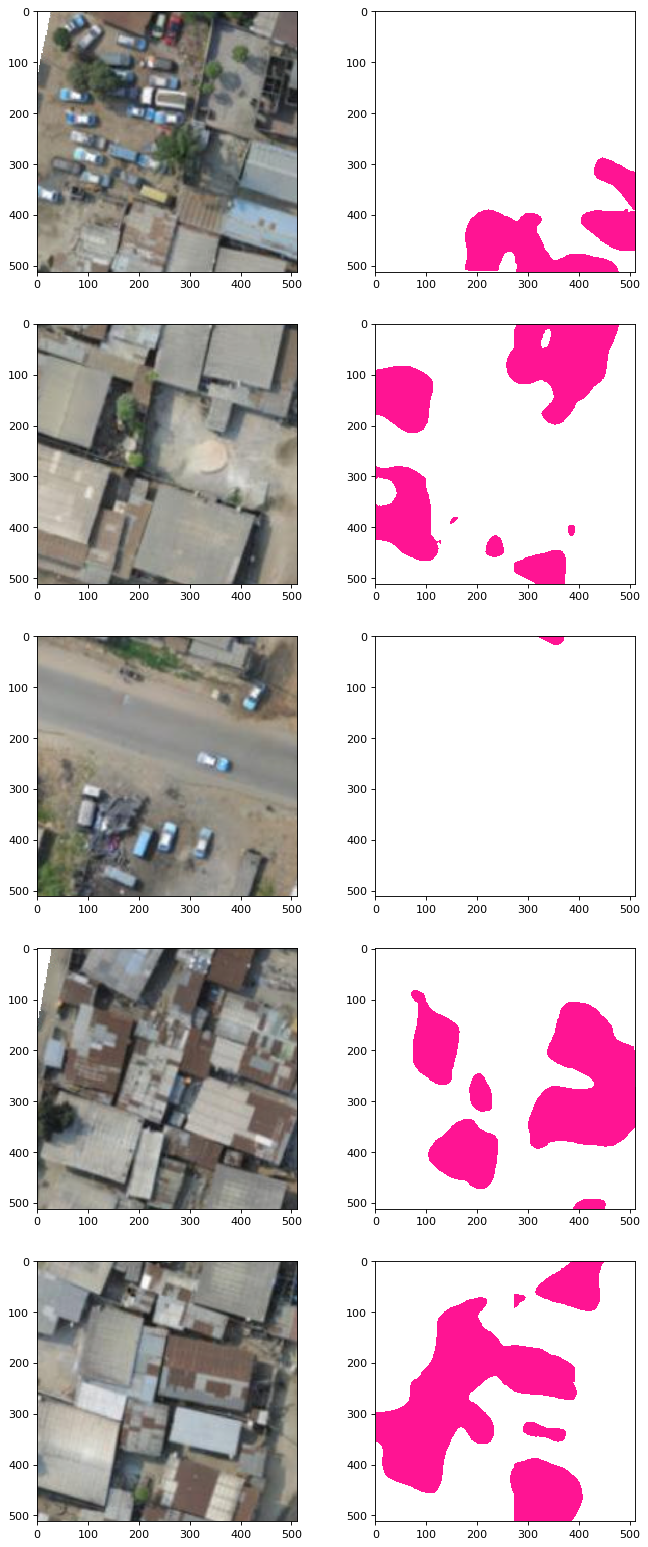

In [0]:
# only 4 images to show

import matplotlib.image as mpimg
from matplotlib.pyplot import figure, imshow, axis
import glob
from skimage.io import imread

number_of_images = 5

images = sorted(glob.glob('predict/images/20/*/*.tiff', recursive=True))[:number_of_images]
masks = sorted(glob.glob('predict/masks/20/*/*.png', recursive=True))[:number_of_images]

fig = figure(num=None, dpi=80, figsize=(10, number_of_images*5), facecolor='w', edgecolor='k')
rows = number_of_images
cols = 2

for i in range(0, rows):
    # print(images[i])
    a=fig.add_subplot(rows, cols, 2*i+1)
    image = imread(images[i])
    imshow(image)

    # print(masks[i])
    b=fig.add_subplot(rows, cols, 2*i+2)
    image = imread(masks[i])
    imshow(image)

In [0]:
|